Este notebook segue a seguinte estrutura:
1. **Leitura e subamostragem** de dados (por exemplo, de 10min para 1h).
2. **Limpeza** e **Engenharia de Atributos** (ex.: vetor de vento, periodicidade).
3. **Normalização** e divisão em **treino/validação/teste**.
4. **Criação de janelas** (`WindowGenerator`) e **Modelos**:
   - *Single-step* (1 hora à frente) 
     - Baseline (retorna o valor atual como previsão)
     - Linear
     - Dense
     - CNN e LSTM 
     - Multi-output
   - *Multi-step* (24 horas à frente)
     - Baselines (Last e Repeat)
     - Modelos single-shot (Linear, Dense, CNN, LSTM)
     - Modelo autoregressivo (FeedBack)
5. **Comparação** de desempenhos e conclusões.

Ao final, teremos um pipeline completo para **single-step** e **multi-step** em um único notebook.

## 1) Importação de Bibliotecas

In [4]:
import os
import IPython
import IPython.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
sns.set_style('whitegrid')

print("Versão do TensorFlow:", tf.__version__)

2024-12-31 11:07:49.016142: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-31 11:07:49.160194: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-31 11:07:49.273769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735654069.408804    9466 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735654069.449233    9466 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 11:07:49.705189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Versão do TensorFlow: 2.18.0


## 2) Leitura e Subamostragem
Suponha que o dataset tenha medições a cada 10 minutos, mas queremos uma amostra por hora. Fatiamos (slice) a partir do índice 5, pegando 1 linha a cada 6, resultando em registros de hora em hora.

In [5]:
#zip_path = tf.keras.utils.get_file(
#    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
#    fname='jena_climate_2009_2016.csv.zip',
#    extract=True)
#csv_path, _ = os.path.splitext(zip_path)

In [6]:
csv_path = 'jena_climate_2009_2016.csv'

df = pd.read_csv(csv_path)
print("Shape original:", df.shape)
df = df[5::6]  # subamostragem de 10min para 1h
print("Shape após subamostragem (1h):", df.shape)
df.head()

Shape original: (420551, 15)
Shape após subamostragem (1h): (70091, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


### Convertendo Datas para `datetime`
A coluna `'Date Time'` é convertida em `datetime` e removida do `DataFrame`. Vamos armazená-la em `date_time` para usar como índice em plots.

In [7]:
date_time = pd.to_datetime(
    df.pop('Date Time'),
    format='%d.%m.%Y %H:%M:%S'
)
print("Exemplo de date_time:", date_time.head())
df.head()

Exemplo de date_time: 5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
Name: Date Time, dtype: datetime64[ns]


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


## 3) Exploração e Limpeza Inicial
### 3.1 Estatísticas e Visualização

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


- `['T (degC)', 'p (mbar)', 'rho (g/m**3)']`: escolhemos temperatura, pressão e densidade para exemplificar a evolução dessas variáveis no tempo.

- No segundo grafico, pegamos apenas as 480 primeiras linhas (ou seja, 480 horas ≈ 20 dias), para ver o comportamento em um intervalo menor. Dessa forma, é possível inspecionar em detalhe como as variáveis mudam em um curto período.

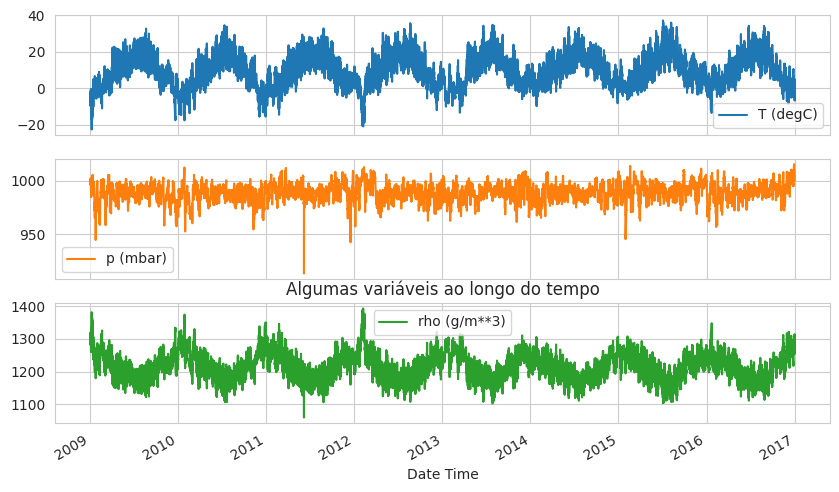

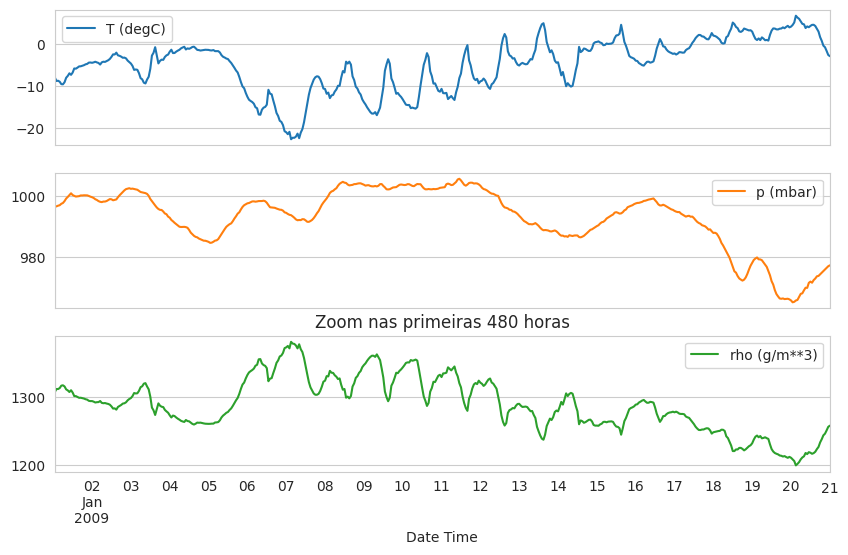

In [9]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols].copy()
plot_features.index = date_time
plot_features.plot(subplots=True)
plt.title("Algumas variáveis ao longo do tempo")
plt.show()

# Zoom nas primeiras 480h
plot_features_zoom = df[plot_cols][:480].copy()
plot_features_zoom.index = date_time[:480]
plot_features_zoom.plot(subplots=True)
plt.title("Zoom nas primeiras 480 horas")
plt.show()

### 3.2 Valores Anômalos (ex.: -9999 em `wv (m/s)`)
Corrigimos valores inválidos substituindo-os por 0.

In [10]:
if 'wv (m/s)' in df.columns:
    bad_wv = df['wv (m/s)'] == -9999.0
    df.loc[bad_wv, 'wv (m/s)'] = 0.0
if 'max. wv (m/s)' in df.columns:
    bad_max_wv = df['max. wv (m/s)'] == -9999.0
    df.loc[bad_max_wv, 'max. wv (m/s)'] = 0.0

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


## 4) Engenharia de Atributos
### 4.1 Vetores de Vento (Wx, Wy)
Transformamos `(velocidade, direção)` em `(Wx, Wy)` para evitar problemas de ângulos (0° e 360°). A motivação é que trabalhar com direções em graus (0° a 360°) pode confundir o modelo, pois 360° e 0° representam a mesma direção. Além disso, se o vento não estiver soprando, o ângulo deixa de ser relevante.

In [11]:
import numpy as np

if 'wd (deg)' in df.columns and 'wv (m/s)' in df.columns:
    wv = df.pop('wv (m/s)')
    max_wv = df.pop('max. wv (m/s)') if 'max. wv (m/s)' in df.columns else None
    wd_rad = df.pop('wd (deg)') * np.pi/180 # Converte para radianos

    df['Wx'] = wv*np.cos(wd_rad) # Transformacao p/ coordenadas polares para cartesianas
    df['Wy'] = wv*np.sin(wd_rad)
    if max_wv is not None:
        df['max Wx'] = max_wv*np.cos(wd_rad)
        df['max Wy'] = max_wv*np.sin(wd_rad)
    print("Convertidos wd e velocidade para Wx, Wy.")
df.head()

Convertidos wd e velocidade para Wx, Wy.


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843


#### 4.1.1 Resumo da Transformação de Coordenadas de Vento

A transformação de coordenadas do vento de polares para cartesianas envolve converter a direção e velocidade do vento em componentes x e y. Esta transformação é essencial para análises meteorológicas e de dados. Abaixo estão as fórmulas usadas para essa conversão:

**Conversão de Graus para Radianos:**
- A direção do vento é dada em graus e precisa ser convertida para radianos para uso nas funções trigonométricas:
  $$
  \text{radianos} = \text{graus} \times \frac{\pi}{180}
  $$

**Cálculo das Componentes Cartesianas:**
- **Componente x (Wx):** Representa a projeção do vento no eixo x.
  $$
  Wx = wv \cdot \cos(\text{radianos})
  $$
- **Componente y (Wy):** Representa a projeção do vento no eixo y.
  $$
  Wy = wv \cdot \sin(\text{radianos})
  $$


Se a máxima velocidade do vento (`max. wv (m/s)`) também estiver disponível, as mesmas fórmulas são aplicadas para calcular as máximas componentes cartesianas (`max Wx` e `max Wy`).

### 4.2 Periodicidade Diária e Anual
A coluna de data/hora em si não é diretamente útil como string ou mesmo em segundos, pois se trata de dados sazonais (com variação diária e anual).

A frequência angular $(\omega)$ relaciona-se com a frequência \( f \) através da fórmula $(\omega = 2\pi f )$. Aplicando isso ao contexto de sinais diários e anuais, onde $f$ é a frequência de ciclos por unidade de tempo (dia ou ano), podemos derivar as fórmulas para os sinais diário e anual:

### Sinal Diário:
- Considerando que um dia tem 86400 segundos e queremos que o sinal complete um ciclo ($(2\pi) radianos$) em um dia, definimos a frequência $f$ como 1 ciclo por dia. Assim, a frequência angular $(\omega)$ para o sinal diário é:
  $$
  \omega_{\text{day}} = 2\pi \times 1\text{/dia} = \frac{2\pi}{86400 \text{ segundos}}
  $$
- As fórmulas para o sinal diário se tornam:
  $$
  \text{Day sin} = \sin(\omega_{\text{day}} \times \text{timestamp}_s)
  $$
  $$
  \text{Day cos} = \cos(\omega_{\text{day}} \times \text{timestamp}_s)
  $$

### Sinal Anual:
- Considerando que um ano tem cerca de 31536000 segundos e queremos um ciclo ($(2\pi) radianos$) por ano, a frequência angular $(\omega)$ para o sinal anual é:
  $$
  \omega_{\text{year}} = 2\pi \times 1\text{/ano} = \frac{2\pi}{31536000 \text{ segundos}}
  $$
- As fórmulas para o sinal anual se tornam:
  $$
  \text{Year sin} = \sin(\omega_{\text{year}} \times \text{timestamp}_s)
  $$
  $$
  \text{Year cos} = \cos(\omega_{\text{year}} \times \text{timestamp}_s)
  $$

Essas fórmulas permitem que modelos de machine learning identifiquem padrões temporais cíclicos, aproveitando as propriedades das funções trigonométricas para capturar a sazonalidade nos dados de forma eficaz.


In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp) # Converte para segundos
day = 24*60*60 # 24h em segundos
year = 365.2425*day # 1 ano em segundos

df['Day sin'] = np.sin(timestamp_s*(2*np.pi/day)) # 
df['Day cos'] = np.cos(timestamp_s*(2*np.pi/day))
df['Year sin'] = np.sin(timestamp_s*(2*np.pi/year)) # 
df['Year cos'] = np.cos(timestamp_s*(2*np.pi/year))
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


Text(0.5, 1.0, 'Time of day signal')

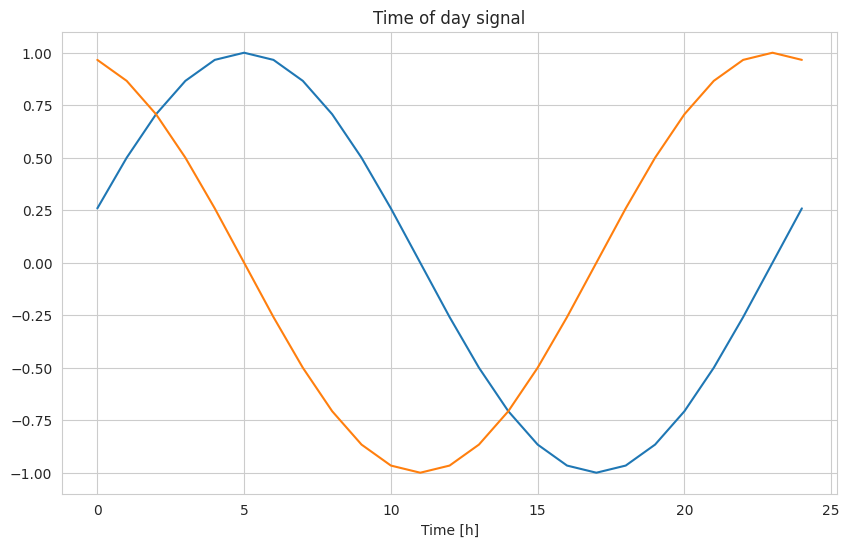

In [13]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Ao plotar as primeiras 25 amostras de `Day sin` e `Day cos` observamos curvas de seno e cosseno defasadas, confirmando essa representação periódica.

Para reforçar essa análise, podemos usar Transformada Rápida de Fourier (FFT) e observar picos em frequências diárias (1/dia) e anuais (1/ano).
- `tf.signal.rfft(df['T (degC)'])` dá a transformada real dos valores de temperatura; ao plotar `np.abs(fft)` em escala logarítmica, vê-se picos nas frequências de 1/ano e 1/dia, como esperado para dados climáticos.

2024-12-31 11:07:55.073560: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


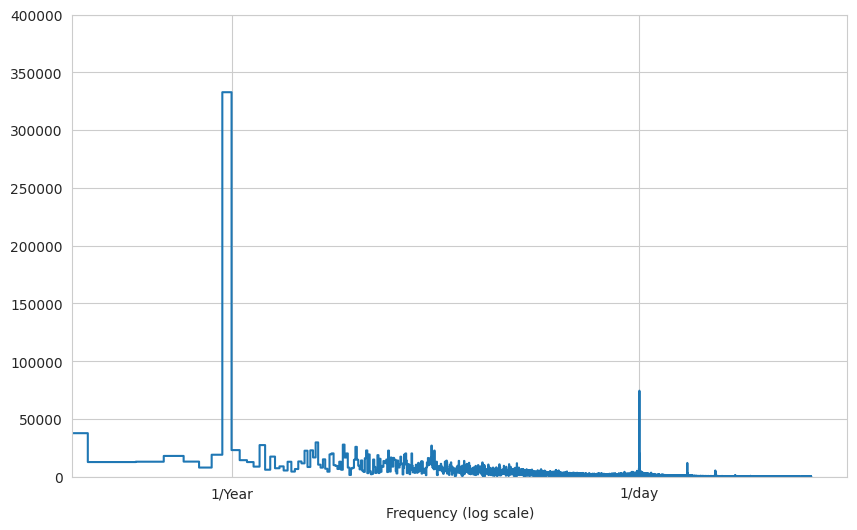

In [14]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## 5) Divisão em Treino/Validação/Teste e Normalização

A escolha de não embaralhar (no shuffle) ocorre por duas razões:

1. **Janelas temporais consecutivas:** embaralhar quebraria a estrutura temporal, inviabilizando a criação de janelas de treino que respeitem a sequência real dos dados.
2. **Avaliação realista:** usar dados futuros para validação e teste simula um cenário de previsão mais próximo do mundo real (o modelo só recebe dados do “passado” para prever dados do “futuro”).

/tmp/ipykernel_9466/2728742204.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


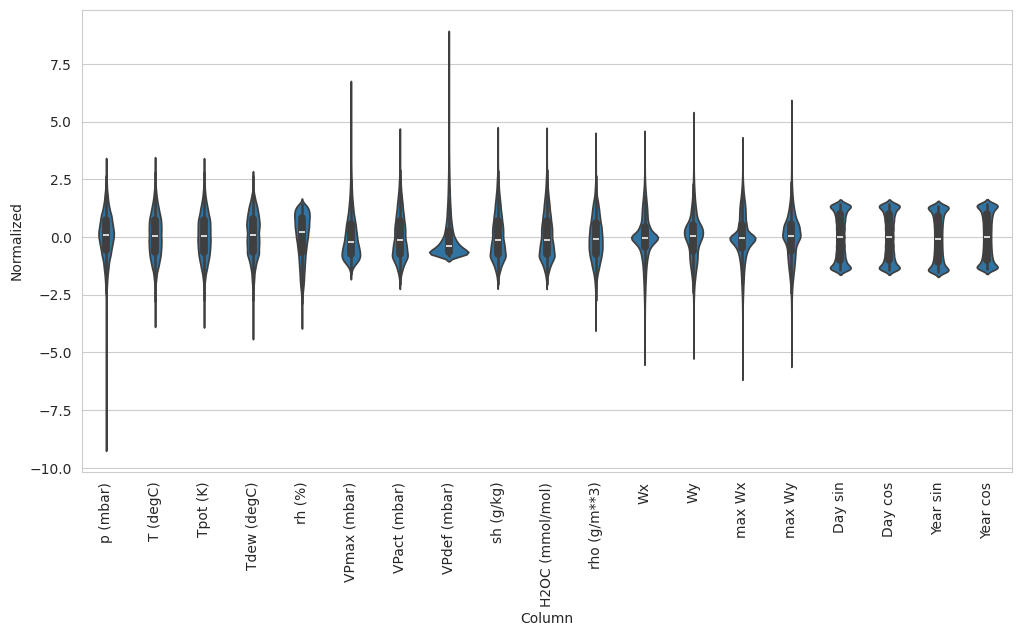

In [15]:
# dicionário mapeando cada nome de coluna (como 'T (degC)', 'p (mbar)', etc.) para um índice inteiro. 
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df) #captura o número total de amostras do dataframe.
train_df = df[:int(n*0.7)] # pega 70% das primeiras linhas para treino.
val_df   = df[int(n*0.7):int(n*0.9)] #pega os 20% seguintes para validação.
test_df  = df[int(n*0.9):]  # pega os 10% finais para teste.

num_features = df.shape[1] #  armazena o número total de colunas do df. Será útil para definir o tamanho de entrada/saída nos modelos.

train_mean = train_df.mean() # são vetores que contêm a média e o desvio padrão de cada coluna
train_std  = train_df.std() # calculados somente nos dados de treino.

df_std = (df - train_mean) / train_std # normaliza 
df_std = df_std.melt(var_name='Column', value_name='Normalized') #
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

O violin plot exibe a distribuição dos valores normalizados de cada coluna. Algumas colunas apresentam tails (caudas longas) mais acentuadas, mas não há valores errôneos (como -9999).

Após essa inspeção, normaliza-se **cada subconjunto** (treino, validação e teste) usando `train_mean` e `train_std`:

In [16]:
def normalize(df, mean, std):
    return (df - mean) / std

train_df = normalize(train_df, train_mean, train_std)
val_df   = normalize(val_df, train_mean, train_std)
test_df  = normalize(test_df, train_mean, train_std)

print("Tamanho:", train_df.shape, val_df.shape, test_df.shape)

Tamanho: (49063, 19) (14018, 19) (7010, 19)


> IMPORTANTE:

- Essa padronização gera dados cujos valores, por coluna, aproximam-se de uma distribuição com média 0 e desvio padrão 1 — porém **apenas** baseada nos valores de *treino*.
- Tanto `val_df` quanto `test_df` não devem influenciar as estatísticas usadas; isso garantiria um *leakage* (vazamento de informação) do futuro.

### 5.1) Por que Normalizar Usando Apenas o Treino?

1. **Simula cenário real:**
Em produção, você nunca terá acesso às estatísticas do futuro. A normalização em problemas de time series costuma sempre se basear apenas em dados históricos ou janelas móveis de dados.

2. **Evita *data leakage***:
Se as estatísticas (média e desvio) fossem calculadas em todo o dataset, os dados de validação e teste teriam fornecido informações sobre seu valor médio ou variabilidade ao modelo de alguma forma, influenciando o treino.

3. **Facilita treinamento:**
A normalização estabiliza as escalas dos atributos, ajudando os métodos de otimização (e.g. *gradient descent*) a convergirem mais rapidamente.

## 6) Classe `WindowGenerator`

O objetivo aqui é organizar os dados em janelas (ou windows) para que o modelo possa receber uma sequência de observações recentes (entradas) e produzir uma sequência ou um único valor de saída (rótulos/labels).

In [17]:
class WindowGenerator:
    def __init__(
        self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df,
        label_columns=None
    ):
        # Armazena dataframes crus
        # O construtor recebe os DataFrames de treino, validação e teste para gerar windows de cada um desses conjuntos.
        self.train_df = train_df
        self.val_df   = val_df
        self.test_df  = test_df

        # Armazena as colunas de rótulos
        self.label_columns = label_columns # lista com os nomes das colunas que queremos prever.
        if label_columns is not None: # Se não for None, a classe cria um dicionário label_columns_indices para mapear cada nome de coluna de rótulo para o índice correspondente.
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} # mapeia todas as colunas do train_df para seus respectivos índices (0, 1, 2, ...), útil no momento de extrair as colunas corretas do batch de dados.

        # Parâmetros da janela
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) # define o fatiamento (range) para as amostras de entrada (vai de 0 até input_width-1).
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width # marca a posição de início dos rótulos dentro de cada janela.
        self.labels_slice = slice(self.label_start, None) # define o slice final para rótulos (do label_start até o fim da janela).
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice] # são arrays com a posição exata de cada passo de entrada e saída, respectivamente.

    # permite que, ao imprimir o objeto, vejamos informações de depuração:
    # tamanho total da janela, quais índices pertencem à entrada e quais pertencem ao rótulo, e quais colunas estamos prevendo.
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

    def split_window(self, features): #Recebe um batch de janelas, com formato (batch, total_window_size, num_features).
        inputs = features[:, self.input_slice, :] # pegamos do índice 0 até input_width-1 ao longo do eixo “tempo”.
        labels = features[:, self.labels_slice, :] # extraindo as posições do tempo que correspondem ao(s) rótulo(s).
 
        if self.label_columns is not None: #(por exemplo, ['T (degC)']), o código empilha somente essas colunas desejadas para o rótulo
            labels = tf.stack([
                labels[:, :, self.column_indices[name]] for name in self.label_columns
            ], axis=-1) 
        #Ajustando a forma (shape) para inspeção
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32) # converte o DataFrame em um array numpy, Tensor.
        ds = tf.keras.utils.timeseries_dataset_from_array( #gera um objeto tf.data.Dataset para dados de séries temporais.
            data=data,
            targets=None, #não definimos rótulos aqui, pois vamos mapeá-los depois com split_window.
            sequence_length=self.total_window_size, #o comprimento total da janela (por ex., 6 + 1 no caso de w2, ou 24 + 24 no caso de w1).
            sequence_stride=1, #cada janela começa apenas 1 passo após a anterior.
            shuffle=True, # embaralha a ordem dos exemplos para evitar correlações na ordem de treino.
            batch_size=32, # cada batch terá 32 janelas.
        )
        ds = ds.map(self.split_window) # A função self.split_window (definida anteriormente) pega cada janela (tensor) e retorna (inputs, labels) com os formatos corretos.
        return ds #é um tf.data.Dataset onde cada elemento é (inputs, labels), pronto para ser consumido pelo modelo.
    
    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            # Rótulos (Labels)
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            # Se um modelo for passado, também plota as previsões
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

# 7) **Single-step Models**
Nessa etapa, queremos prever **apenas 1 hora** à frente, com base em 1 hora (ou várias horas) de histórico.

### 7.1 Exemplo de janela single-step (`input_width=1`, `label_width=1`, `shift=1`)
Modelo mais simples de janela:
- `input_width=1`: O modelo só terá acesso a 1 ponto de entrada por vez (por exemplo, as leituras da hora atual).
- `label_width=1`: Queremos prever apenas 1 passo à frente (1 hora no futuro).
- `shift=1`: Esse rótulo está deslocado exatamente 1 passo temporal em relação ao início da janela.
- `label_columns=['T (degC)']`: Prevemos apenas a coluna de temperatura.

In [18]:
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df
)
print(single_step_window)
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

#single_step_window.plot()

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


2024-12-31 11:08:01.403754: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


`Inputs shape (batch, time, features): (32, 1, 19)` : Temos batch_size de 32 janelas; em cada janela há 1 passo de tempo e 19 features (todas as colunas).

`Labels shape (batch, time, features): (32, 1, 1)` : Rótulo com 1 passo de tempo e 1 feature (temperatura), pois label_columns é só `['T (degC)']`

### 7.2 Baseline para Single-step
Antes de criar modelos treináveis, é fundamental ter uma **referência** de desempenho mínima. Esse baseline não aprende nada; ele apenas retorna a **temperatura atual** como previsão do próximo passo — ou seja, assume que **não haverá mudança** em 1 hora. Em muitos problemas, esse tipo de suposição simples já pode ser um comparativo válido.

In [19]:
val_performance = {}
performance = {}

class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index # indica em qual coluna do input (entre as muitas features) está a feature que queremos “espelhar” para a saída 
    def call(self, inputs):
        if self.label_index is None: # retorna todas as features de entrada sem mudança.
            return inputs
        result = inputs[:, :, self.label_index] # extrai apenas a coluna self.label_index do tensor inputs (no eixo features) e devolve como previsão.
        return result[:, :, tf.newaxis]

# Instancia
baseline = Baseline(label_index=train_df.columns.get_loc('T (degC)'))
baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae'] #tf.keras.metrics.MeanAbsoluteError()
)

val_performance['Baseline'] = baseline.evaluate(
    single_step_window.val, # retorna um dicionário com valores de loss e mean_absolute_error no conjunto de validação.
    return_dict=True
)
performance['Baseline'] = baseline.evaluate(
    single_step_window.test, # o mesmo para o conjunto de teste.
    verbose=0,
    return_dict=True
)
val_performance['Baseline']

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0133 - mae: 0.0789


{'loss': 0.01284564845263958, 'mae': 0.07846628129482269}

Aqui temos algumas métricas de desempenho, mas elas não dão uma sensação de quão bem o modelo está se saindo.

O `WindowGenerator` tem um método de plotagem, mas os gráficos não são muito interessantes com apenas uma única amostra.

Então, criaremos um `WindowGenerator` mais amplo que gere janelas de 24 horas de entradas e rótulos consecutivos de cada vez. A nova variável `wide_window` não muda a forma como o modelo opera. O modelo ainda faz previsões uma hora no futuro com base em um único passo de tempo de entrada. Aqui, cada previsão é feita de forma independente, sem interação entre os passos de tempo:

In [20]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

![](images/last_window.png)

Esta janela pode ser passada diretamente para o mesmo modelo baseline sem qualquer alteração no código. Isso é possível porque as entradas e os rótulos têm o mesmo número de passos de tempo, e o baseline apenas encaminha a entrada para a saída:

In [21]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Ao plotar as previsões do modelo baseline, note que ele **simplesmente desloca os rótulos para a direita** em uma hora:

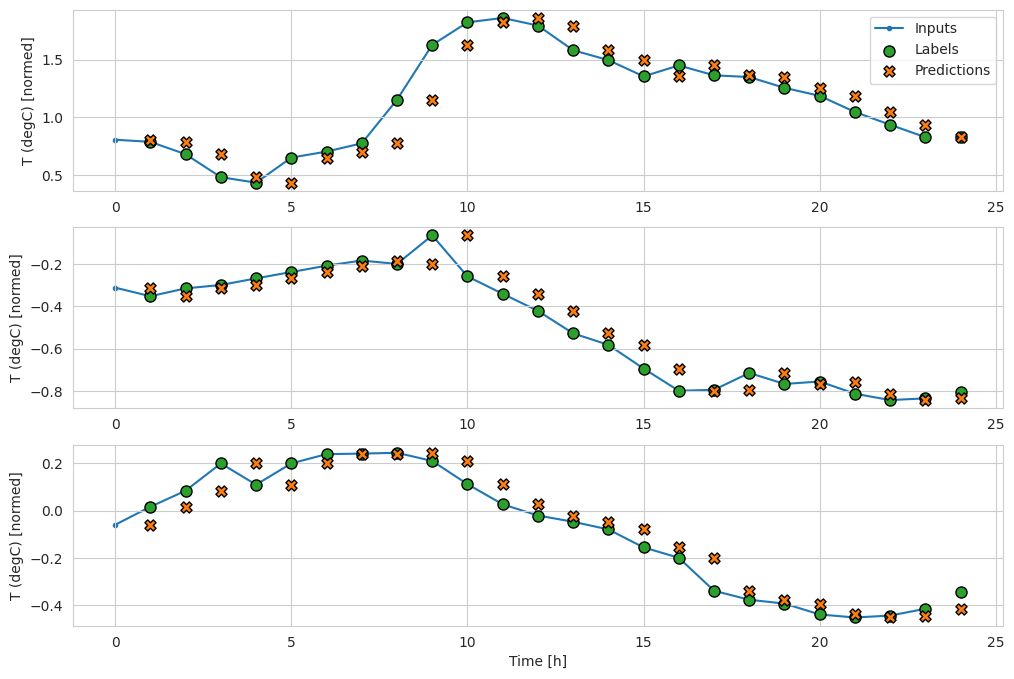

In [22]:
wide_window.plot(baseline)


Nos gráficos acima de três exemplos, o modelo de passo único é executado ao longo de 24 horas. Isso merece uma explicação:

- A linha azul `Inputs` mostra a temperatura de entrada em cada passo de tempo. O modelo recebe todas as características, mas este gráfico mostra apenas a temperatura.
- Os pontos verdes `Labels` mostram o valor alvo da previsão(Labels). Esses pontos são mostrados no momento da previsão, não no momento da entrada. Por isso, a faixa de rótulos é deslocada 1 passo em relação às entradas.
- As cruzes laranjas `Predictions` são as previsões do modelo para cada passo de tempo de saída. Se o modelo estivesse prevendo perfeitamente, as previsões cairiam diretamente sobre os rótulos.


### 7.3 Modelo Linear (Single-step)
O modelo mais simples que podemos treinar p/ esta tarefa é inserir uma transformação linear entre a entrada e a saída. Neste caso, a saída de um passo de tempo depende apenas desse passo:

![](images/narrow_window.png)

In [23]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['mae']
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )
    return history

# Modelo Linear single-step
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

history = compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(
    single_step_window.val,
    return_dict=True
)
performance['Linear'] = linear.evaluate(
    single_step_window.test,
    verbose=0,
    return_dict=True
)
val_performance['Linear']

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)
Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1101 - mae: 0.6508 - val_loss: 0.0256 - val_mae: 0.1222
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0258 - mae: 0.1208 - val_loss: 0.0144 - val_mae: 0.0901
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0134 - mae: 0.0866 - val_loss: 0.0096 - val_mae: 0.0727
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0096 - mae: 0.0720 - val_loss: 0.0088 - val_mae: 0.0692
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091 - mae: 0.0698 - val_loss: 0.0087 - val_mae: 0.0689
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091 - mae: 0.0699 - val_loss: 0.0087 - val_mae: 0.0690
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091 - mae: 0.0699 - val_loss: 0.0087 - val_mae: 0.0689
Epoch 8/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091 - mae: 0.0697 - val_loss: 0.0087 - val_ma

{'loss': 0.008718588389456272, 'mae': 0.06927550584077835}

Assim como o modelo baseline, o modelo linear pode ser chamado em lotes de janelas (batchs). Dessa forma, o modelo faz um conjunto de previsões independentes em passos de tempo consecutivos. Não há interações entre as previsões em cada passo de tempo.
![](images/wide_window.png)

In [24]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)


Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Note que o modelo linear é claramente melhor do que apenas retornar a temperatura de entrada, mas em alguns casos é pior:

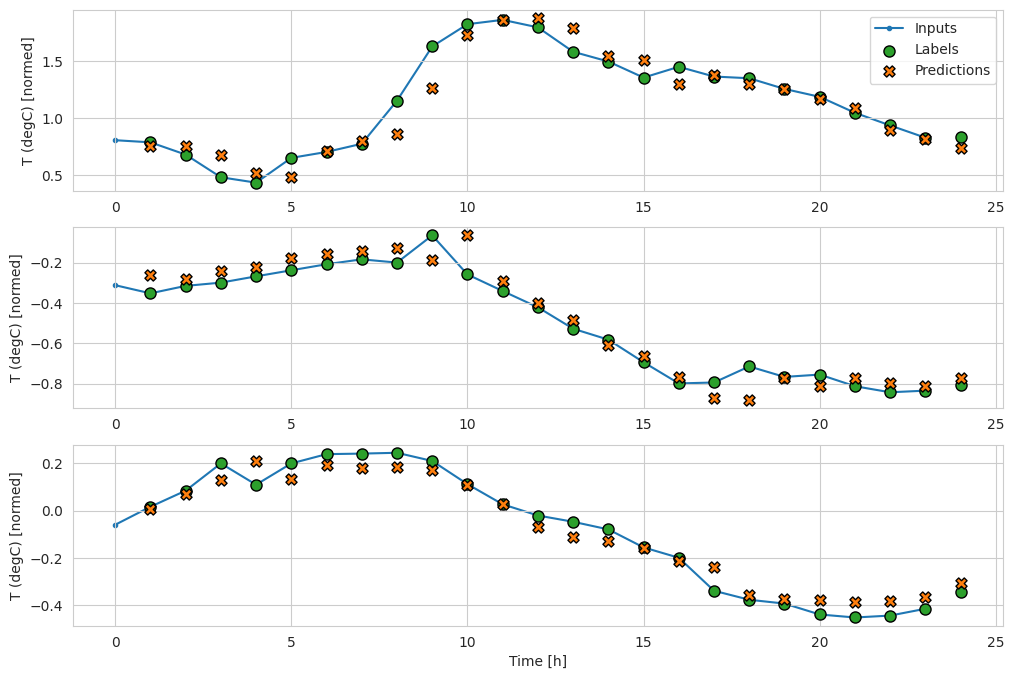

In [25]:
wide_window.plot(linear)


Uma vantagem dos modelos lineares, e que eles sao relativamente simples de intepretar. POdemos visualizar os pesos relacionados a cada feature:

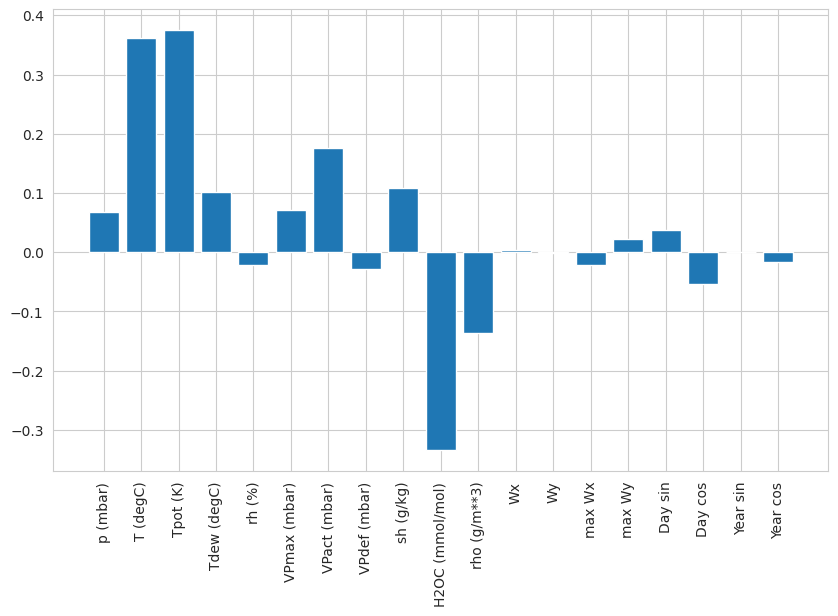

In [26]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


Às vezes, nem mesmo o modelo coloca o maior peso na entrada `T (degC)`. Este é um dos riscos da inicialização aleatória.

### 7.4 Modelo Denso (Single-step)

Antes de aplicar modelos que operam em múltiplos passos de tempo, vale a pena verificar o desempenho de modelos mais 'profundos' e melhores com um único passo de entrada.

Aqui está um modelo semelhante ao modelo linear, exceto que ele empilha várias camadas Dense entre a entrada e a saída:

In [27]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(
    single_step_window.val,
    return_dict=True
)
performance['Dense'] = dense.evaluate(
    single_step_window.test,
    verbose=0,
    return_dict=True
)
val_performance['Dense']

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0301 - mae: 0.1042 - val_loss: 0.0077 - val_mae: 0.0634
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0081 - mae: 0.0655 - val_loss: 0.0075 - val_mae: 0.0615
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0077 - mae: 0.0633 - val_loss: 0.0085 - val_mae: 0.0670
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0075 - mae: 0.0618 - val_loss: 0.0072 - val_mae: 0.0613
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0073 - mae: 0.0608 - val_loss: 0.0067 - val_mae: 0.0581
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0071 - mae: 0.0596 - val_loss: 0.0067 - val_mae: 0.0581
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0070 - mae: 0.0592 - val_loss: 0.0066 - val_mae: 0.0576
Epoch 8/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069 - mae: 0.0590 - val_loss: 0.0070 - val_mae: 0.0587
Epoch 9/20
1534/1534 ━━━━━━━━━━━━━━━━━━━

{'loss': 0.006572900339961052, 'mae': 0.05682308226823807}

### 8) Multi-step Dense (24h no futuro)

Um modelo de passo único(single step) não tem contexto para os valores atuais de suas entradas. Ele não consegue ver como os recursos de entrada estão mudando ao longo do tempo. Para resolver esse problema, o modelo precisa ter acesso a múltiplos instantes de tempo ao fazer previsões:

![](images/conv_window.png)

Os modelos baseline, linear e dense models trataram cada passo de tempo de forma independente. Aqui, o modelo tomará múltiplos instantes de tempo como entrada para produzir uma única saída.

Criaremos entao um `WindowGenerator` que produzirá lotes de entradas de três horas e rótulos de uma hora:

Note que o parâmetro  `Window`'s `shift` é relativo ao final das duas janelas.


In [28]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window


Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

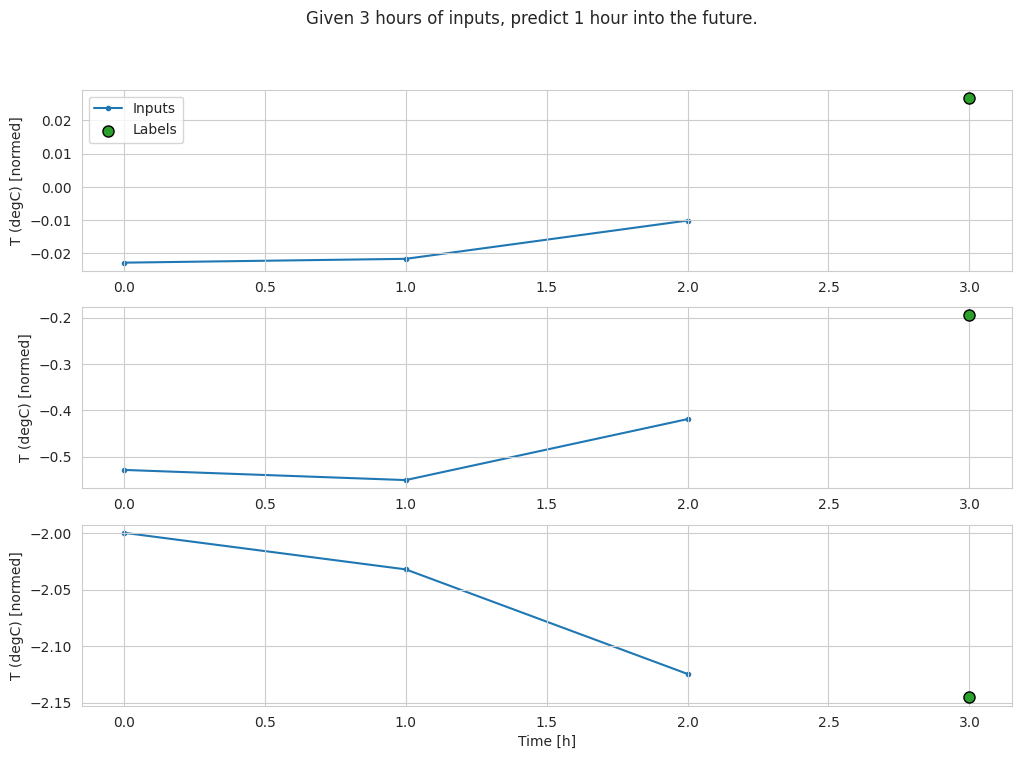

In [29]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")


Podemos treinar um modelo denso em uma janela de múltiplas entradas adicionando uma camada `tf.keras.layers.Flatten` como a primeira camada do modelo:

In [30]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [31]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)


Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [32]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067 - mae: 0.0578


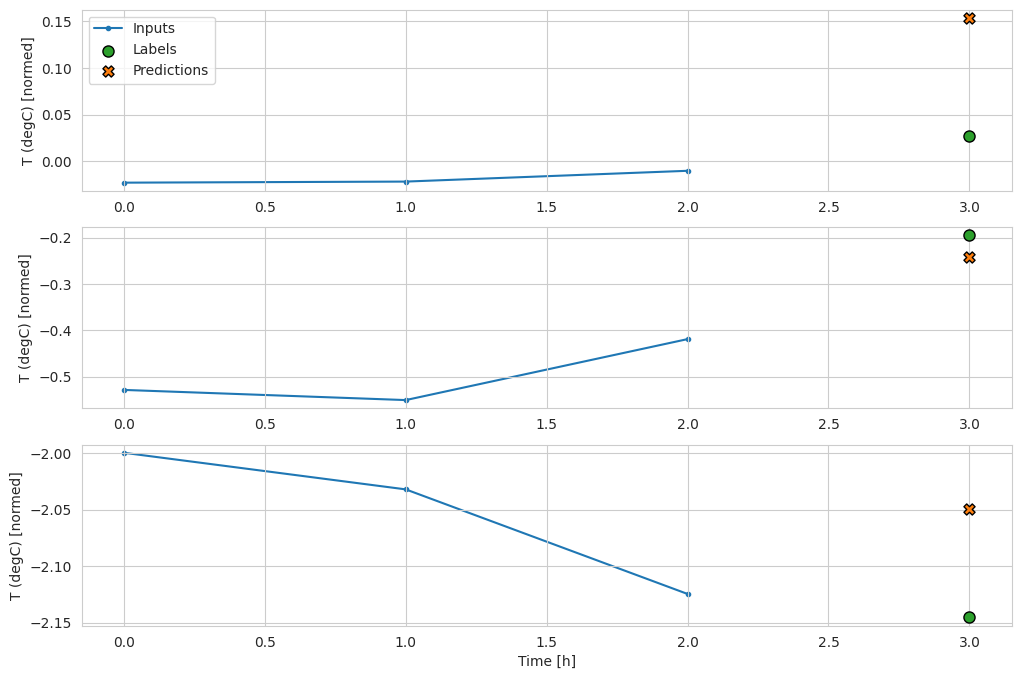

In [33]:
conv_window.plot(multi_step_dense)


A principal desvantagem dessa abordagem é que o modelo resultante só pode ser executado em janelas de entrada exatamente com esse formato.

In [34]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')


Input shape: (32, 24, 19)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


Os modelos convolucionais na próxima seção resolvem esse problema.

### CNN

A camada de convolução `(tf.keras.layers.Conv1D)` também leva múltiplos passos de tempo como entrada para cada previsão.

Abaixo está o **mesmo** modelo que `multi_step_dense`, reescrito com uma convolução.

Note as mudanças:

- A `tf.keras.layers.Flatten` e a primeira `tf.keras.layers.Dense` são substituídas por uma `tf.keras.layers.Conv1D`.
- A `tf.keras.layers.Reshape` não é mais necessária, pois a convolução mantém o eixo do tempo em sua saída.


In [35]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


Execute em um lote de exemplo para verificar se o modelo produz saídas com o formato esperado:

In [36]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Treine e avalie-o na `conv_window` e ele deve apresentar um desempenho semelhante ao modelo `multi_step_dense`.

In [37]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073 - mae: 0.0624


A diferença entre este `conv_model` e o modelo `multi_step_dense` é que o `conv_model` pode ser executado em entradas de qualquer comprimento. A camada convolucional é aplicada a uma janela deslizante de entradas:

![](images/wide_conv_window.png)

Se você executá-lo em uma entrada mais ampla, ele produz uma saída mais ampla:

In [38]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Observe que a saída é mais curta que a entrada. Para que o treinamento ou a plotagem funcionem, precisamos que os rótulos e as previsões tenham o mesmo comprimento. Portanto, vamos construir um `WindowGenerator` para produzir janelas largas com alguns passos de tempo de entrada extras para que o comprimento dos rótulos e das previsões correspondam:

In [39]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1) # 
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window


Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [40]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Agora, podemos plotar as previsões do modelo em uma janela mais ampla. **Note os 3 passos de tempo de entrada antes da primeira previsão**. Cada previsão aqui é baseada nos 3 passos de tempo anteriores:

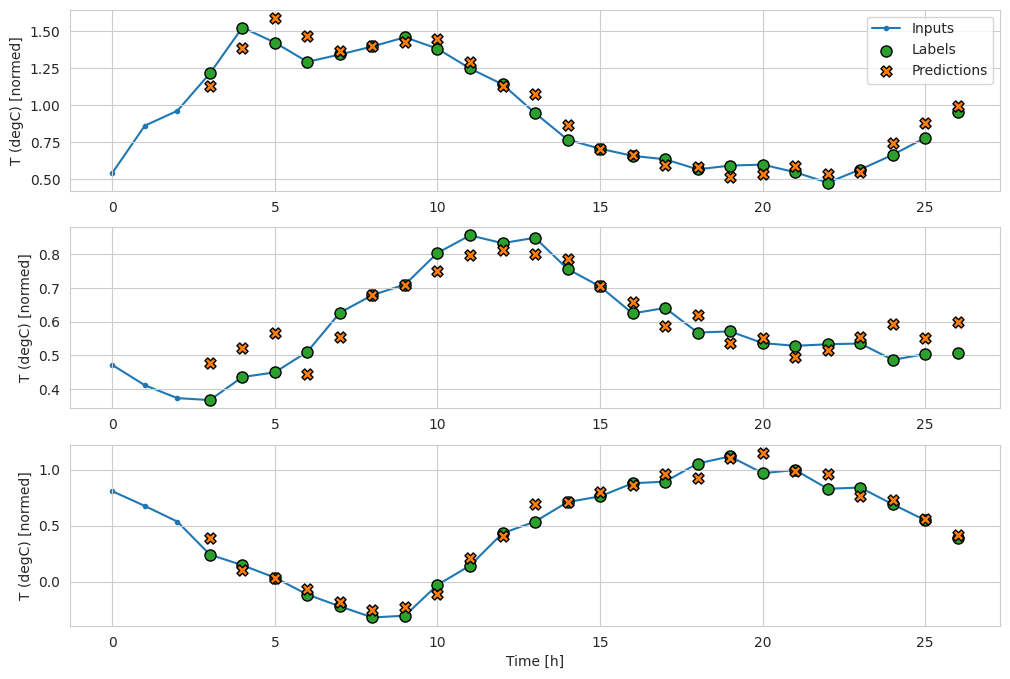

In [41]:
wide_conv_window.plot(conv_model)

### RNN

A `Recurrent Neural Network (RNN)` é um tipo de rede neural bem adequada para dados de séries temporais. RNNs processam uma série temporal passo a passo, mantendo um estado interno de um passo de tempo para o outro.

Para mais infos acesse o tutorial de [Geração de Texto com uma RNN](https://www.tensorflow.org/text/tutorials/text_generation) e o guia [Redes Neurais Recorrentes (RNN) com Keras](https://www.tensorflow.org/guide/keras/rnn).

Neste tutorial, usaremos uma camada RNN chamada Long Short-Term Memory `(tf.keras.layers.LSTM)`.

Um argumento importante do construtor para todas as camadas RNN do Keras, como `tf.keras.layers.LSTM`, é o argumento `return_sequences`. Com isto podemos configurar a camada de duas maneiras:

1. Se `False`, (default), a camada retorna apenas a saída do último passo de tempo, dando ao modelo tempo para *aquecer* seu estado interno antes de fazer uma única previsão:

![](images/lstm_1_window.png)

1. Se `True`, a camada retorna uma saída para cada entrada. Isso é útil para:

- Empilhamento de camadas RNN.
- Treinar um modelo em vários intervalos de tempo simultaneamente.

![](lstm_many_window.png)


In [42]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


Com `return_sequences=True`, o modelo pode ser treinado em 24 horas de dados de uma vez.

> Note: Isso dará uma visão pessimista do desempenho do modelo. No primeiro passo de tempo, o modelo não tem acesso aos passos anteriores e, portanto, não pode fazer melhor do que os modelos lineares e densos simples mostrados anteriormente.

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)


Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [44]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - mae: 0.0521


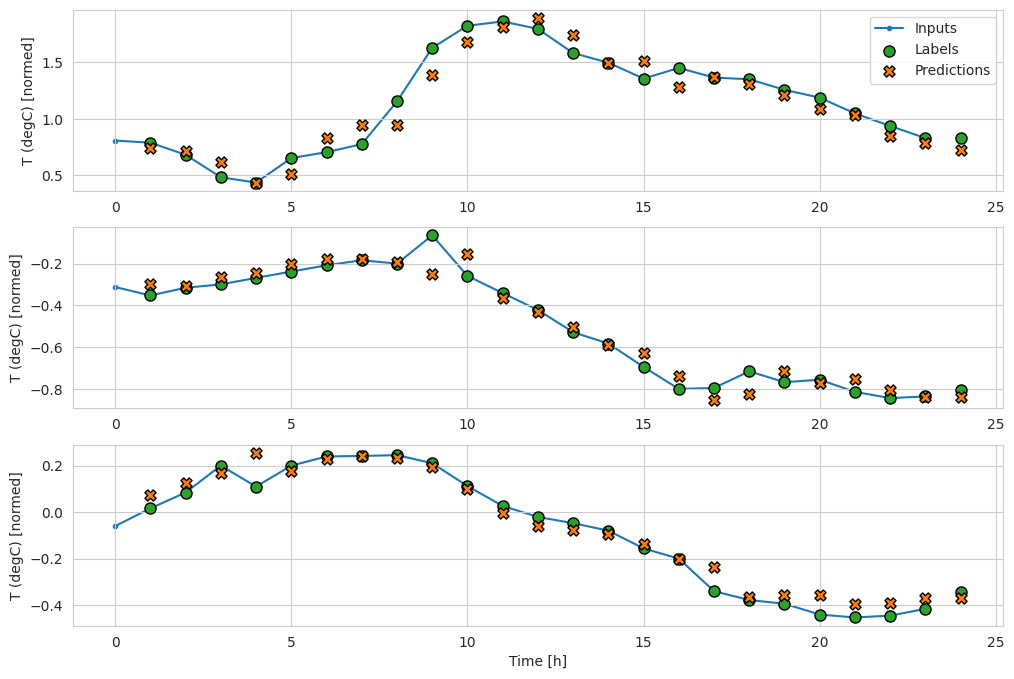

In [45]:
wide_window.plot(lstm_model)

### Performance

Com este conjunto de dados, normalmente cada um dos modelos se sai um pouco melhor do que o anterior:


In [46]:
cm = lstm_model.metrics[1]
cm.metrics


[<MeanAbsoluteError name=mae>]

In [47]:
val_performance


{'Baseline': {'loss': 0.01284564845263958, 'mae': 0.07846628129482269},
 'Linear': {'loss': 0.008718588389456272, 'mae': 0.06927550584077835},
 'Dense': {'loss': 0.006572900339961052, 'mae': 0.05682308226823807},
 'Multi step dense': {'loss': 0.006621680222451687,
  'mae': 0.05723068118095398},
 'Conv': {'loss': 0.007446819916367531, 'mae': 0.06306922435760498},
 'LSTM': {'loss': 0.005632120184600353, 'mae': 0.052126117050647736}}

In [48]:
for name, value in performance.items():
  print(f'{name:12s}: {value['mae']:0.4f}')


Baseline    : 0.0852
Linear      : 0.0675
Dense       : 0.0573
Multi step dense: 0.0574
Conv        : 0.0599
LSTM        : 0.0533


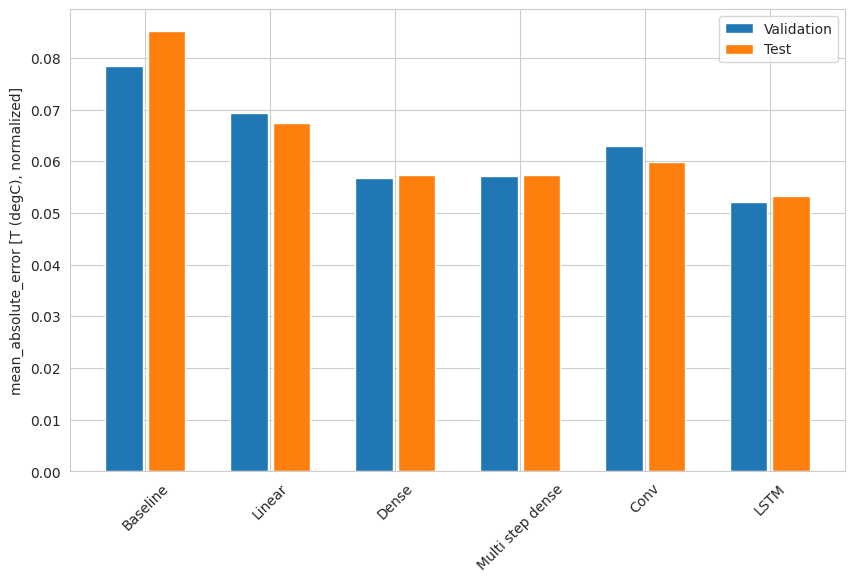

In [49]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mae'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


### Multi-output models

Os modelos até agora previram uma única característica de saída, T (degC), para um único passo temporal (1 passo `a frente).

Todos esses modelos podem ser convertidos para prever várias características apenas mudando o número de unidades na camada de saída e ajustando as janelas de treinamento para incluir todas as características nos `labels` `(example_labels)`.
>Note que ainda estamos trabalhando com modelos Single-step(1 passo a frente)

In [50]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


2024-12-31 11:11:29.625624: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Observe acima que o eixo de recursos dos rótulos agora tem a mesma profundidade das entradas, em vez de 1.
### Baseline
O mesmo modelo de linha de base (`Baseline`) pode ser usado aqui, mas desta vez repetindo todos os recursos em vez de selecionar um `label_index` específico:

In [51]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=['mae']) # tf.keras.metrics.MeanAbsoluteError()


In [52]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0, return_dict=True)


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0879 - mae: 0.1586


### Dense

In [53]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)


439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0687 - mae: 0.1285


### RNN

In [54]:
# %%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0, return_dict=True)

print()


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0611 - mae: 0.1197



### Avançado: Conexões Residuais

O modelo Baseline mencionado anteriormente aproveitou o fato de que a sequência não muda drasticamente de um passo de tempo para o outro. Todos os modelos treinados neste tutorial até agora foram inicializados aleatoriamente e, em seguida, tiveram que aprender que a saída é uma pequena mudança em relação ao passo de tempo anterior.

Embora seja possível contornar esse problema com uma inicialização cuidadosa, é mais simples incorporar isso na estrutura do modelo.

É comum na análise de séries temporais construir modelos que, em vez de prever o próximo valor, preveem como o valor mudará no próximo passo de tempo. Da mesma forma, redes residuais—ou ResNets—na aprendizagem profunda referem-se a arquiteturas onde cada camada adiciona ao resultado acumulado do modelo.

É assim que se aproveita o conhecimento de que a mudança deve ser pequena.

![](images/residual.png)

Essencialmente, isso inicializa o modelo para corresponder ao Baseline. Para esta tarefa, ajuda os modelos a convergirem mais rapidamente, com um desempenho ligeiramente melhor.

Essa abordagem pode ser usada em conjunto com qualquer modelo discutido neste tutorial.

Aqui, está sendo aplicada ao modelo LSTM, observe o uso do `tf.initializers.zeros` para garantir que as mudanças previstas iniciais sejam pequenas e não sobrecarreguem a conexão residual. Não há preocupações de quebra de simetria para os gradientes aqui, já que os zeros são usados apenas na última camada.

In [55]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

#%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0620 - mae: 0.1180



### Performance

Aqui está o desempenho geral desses modelos de múltiplas saídas.

In [56]:
for name, value in performance.items():
  print(f'{name:15s}: {value[metric_name]:0.4f}')


Baseline       : 0.1638
Dense          : 0.1290
LSTM           : 0.1214
Residual LSTM  : 0.1191


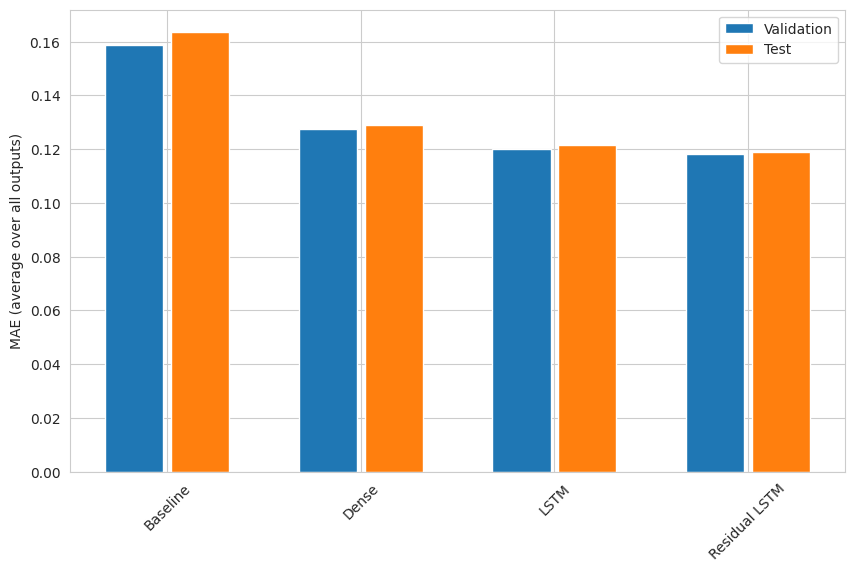

In [57]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mae'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()


# Multi-step models

Tanto os modelos de saída única quanto os de múltiplas saídas nas seções anteriores fizeram **previsões de um único passo temporal**, uma hora no futuro.

Esta seção mostra como expandir esses modelos para fazer **previsões de múltiplos passos temporais**.

Em uma previsão de múltiplos passos, o modelo precisa aprender a prever uma série de valores futuros. Assim, ao contrário de um modelo de passo único, onde apenas um ponto futuro é previsto, um modelo de múltiplos passos prevê uma sequência de valores futuros.

Existem duas abordagens principais para isso:

1. Previsões de tiro único, onde toda a série temporal é prevista de uma vez.
2. Previsões autorregressivas, onde o modelo faz apenas previsões de um único passo e sua saída é realimentada como sua entrada.

Nesta seção, todos os modelos irão prever **todas as características em todos os passos temporais de saída.**

Para o modelo de múltiplos passos, os dados de treinamento novamente consistem em amostras horárias. No entanto, aqui, os modelos aprenderão a prever 24 horas no futuro, dado 24 horas do passado.

Aqui está um objeto Window que gera esses cortes a partir do conjunto de dados:

### 8.1 Criação da Janela Multi-step

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None


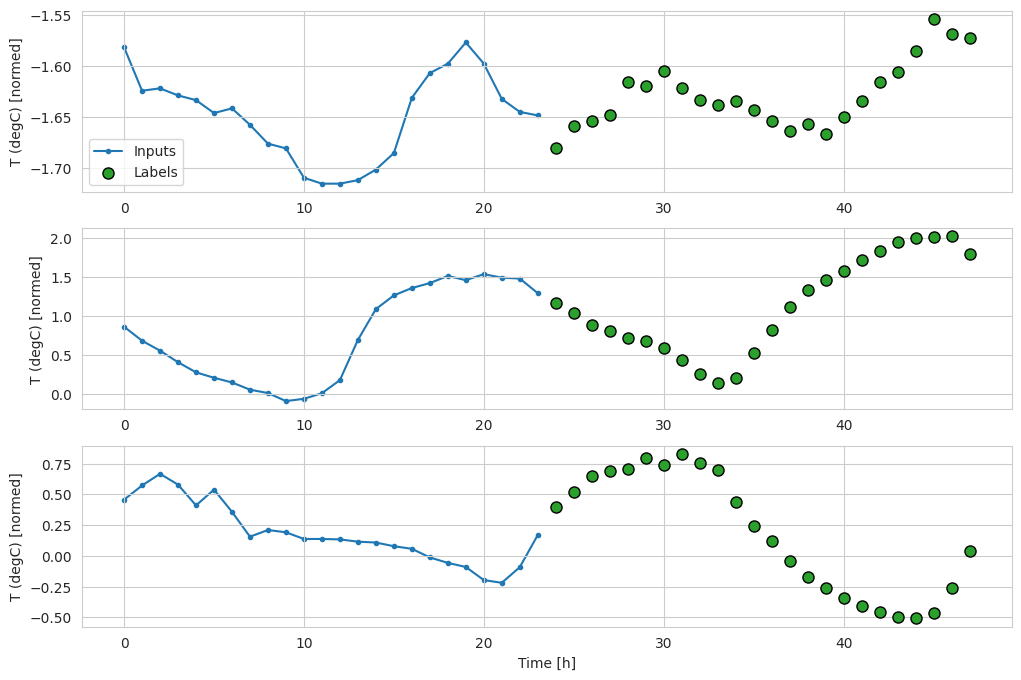

In [58]:
OUT_STEPS = 24
multi_window = WindowGenerator(
    input_width=24,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=None  # => prever todas as colunas
)
print(multi_window)
multi_window.plot()

### 8.2 Baselines Multi-step (Last e Repeat)
1. **MultiStepLastBaseline**: repete o último valor para as 24 horas de saída
2. **RepeatBaseline**: repete todo o histórico de 24h como se o dia seguinte fosse igual ao anterior

![](images/multistep_last.png)

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6334 - mae: 0.5030


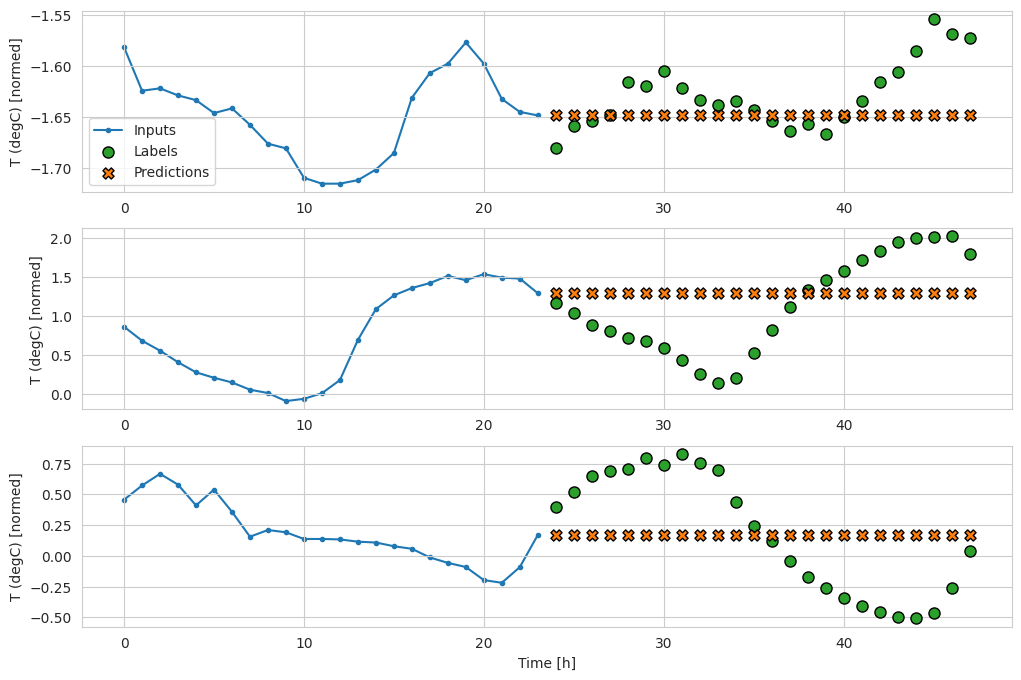

In [59]:
multi_val_performance = {}
multi_performance = {}

class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

# Last
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss='mse', metrics=['mae'])
multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

Como esta tarefa é prever 24 horas no futuro, dado 24 horas do passado, outra abordagem simples é repetir o dia anterior, assumindo que amanhã será semelhante:

![](images/multistep_repeat.png)

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4287 - mae: 0.3964
Multi-step baselines: {'Last': {'loss': 0.6285412311553955, 'mae': 0.5007191300392151}, 'Repeat': {'loss': 0.42702552676200867, 'mae': 0.39587467908859253}}


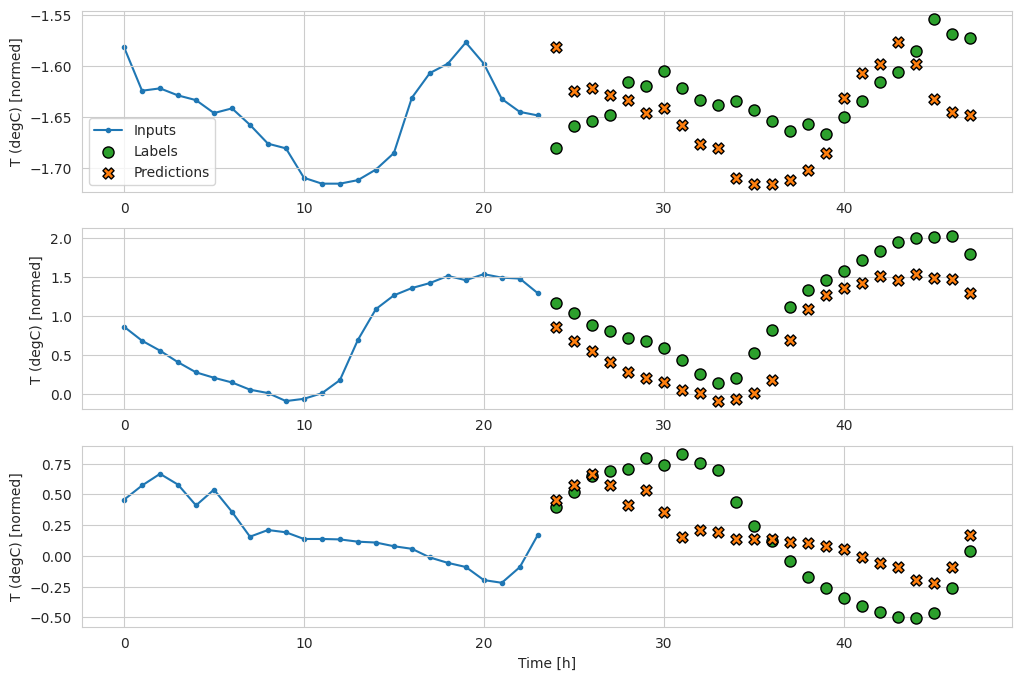

In [60]:
# Repeat
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss='mse', metrics=['mae'])
multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(repeat_baseline)
print("Multi-step baselines:", multi_val_performance)

### 8.3 Modelos multi-step Single-shot: Linear, Dense, CNN, LSTM

Uma abordagem de alto nível para este problema é usar um modelo "single-shot", onde o modelo faz a previsão de toda a sequência em um único passo.

Isso pode ser implementado de forma eficiente como um `tf.keras.layers.Dense` com unidades de saída `OUT_STEPS*features`. O modelo só precisa remodelar essa saída para o formato necessário `(OUTPUT_STEPS, features)`.

### Linear

Um modelo linear simples baseado no último passo de tempo de entrada se sai melhor do que qualquer baseline, mas é subdimensionado. O modelo precisa prever `OUTPUT_STEPS` passos de tempo, a partir de um único passo de tempo de entrada com uma projeção linear. Ele só pode capturar uma fatia de baixa dimensão do comportamento, provavelmente baseada principalmente na hora do dia e na época do ano.

![](images/multistep_dense.png)

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4352 - mae: 0.4789 - val_loss: 0.2595 - val_mae: 0.3237
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2588 - mae: 0.3179 - val_loss: 0.2563 - val_mae: 0.3061
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2573 - mae: 0.3082 - val_loss: 0.2562 - val_mae: 0.3055
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2572 - mae: 0.3079 - val_loss: 0.2561 - val_mae: 0.3054
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2571 - mae: 0.3079 - val_loss: 0.2561 - val_mae: 0.3054
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2571 - mae: 0.3078 - val_loss: 0.2561 - val_mae: 0.3053
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2570 - mae: 0.3059


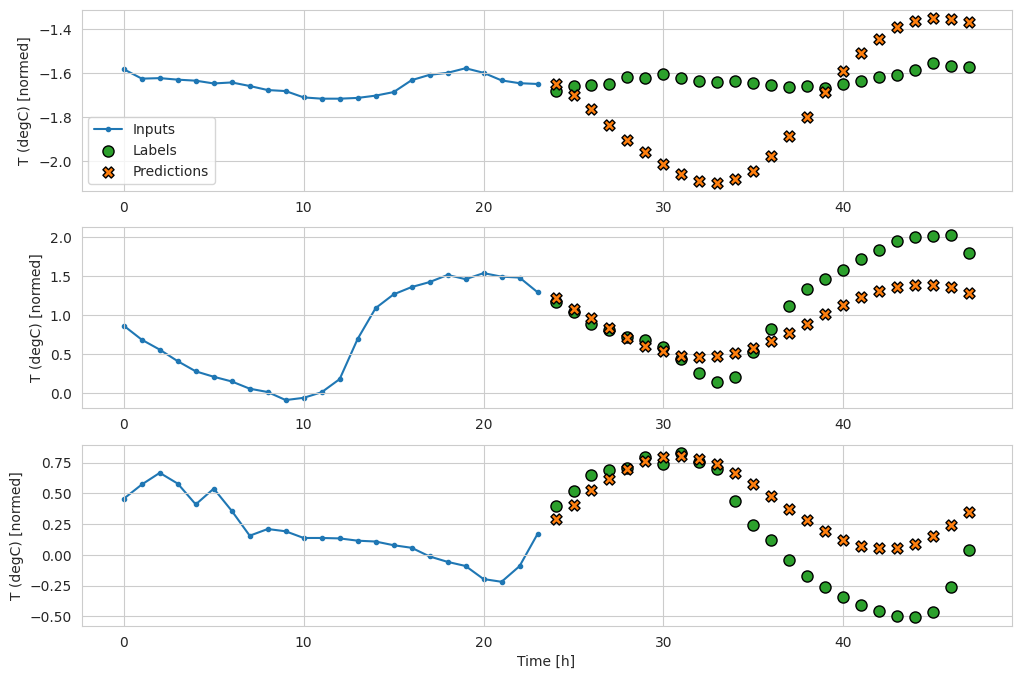

In [61]:
# 1) Multi-step Linear
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(OUT_STEPS * train_df.shape[1], kernel_initializer=tf.zeros_initializer()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[1]])
])
history = compile_and_fit(multi_linear_model, multi_window)
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_linear_model)

### 2) Multi-step Dense

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2803 - mae: 0.3372 - val_loss: 0.2279 - val_mae: 0.2889
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2235 - mae: 0.2858 - val_loss: 0.2280 - val_mae: 0.2893
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2202 - mae: 0.2828 - val_loss: 0.2241 - val_mae: 0.2860
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2171 - mae: 0.2803 - val_loss: 0.2223 - val_mae: 0.2843
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2150 - mae: 0.2785 - val_loss: 0.2225 - val_mae: 0.2850
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2135 - mae: 0.2772 - val_loss: 0.2212 - val_mae: 0.2830
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2122 - mae: 0.2763 - val_loss: 0.2213 - val_mae: 0.2830
Epoch 8/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2113 - mae: 0.2756 - val_loss: 0.2219 - val_mae: 0.2834
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 

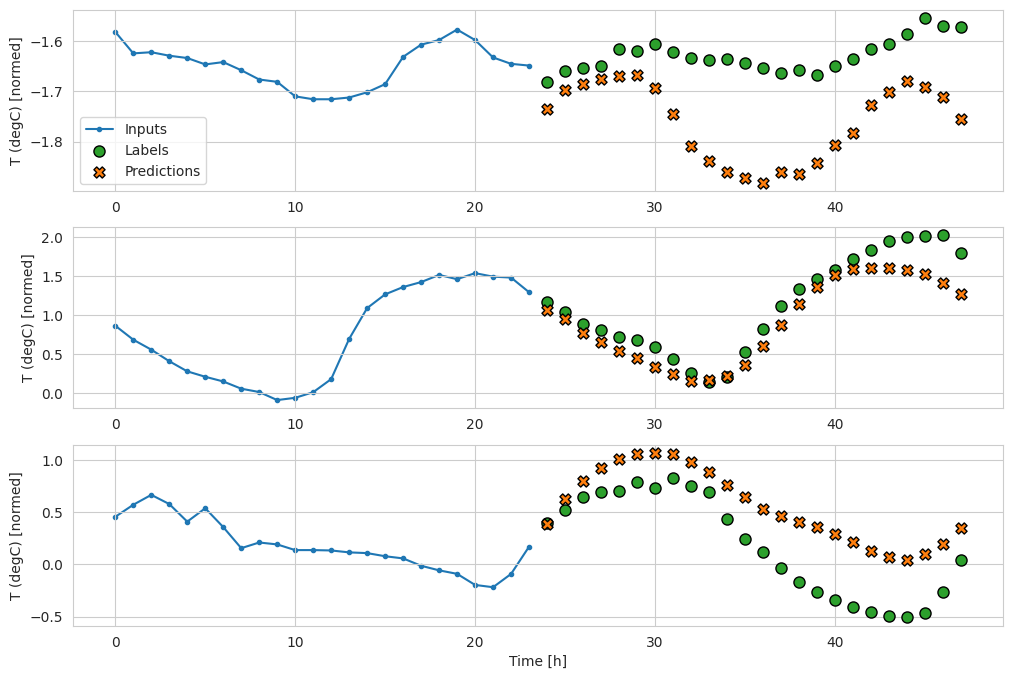

In [62]:

multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*train_df.shape[1], kernel_initializer=tf.zeros_initializer()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[1]])
])

history = compile_and_fit(multi_dense_model, multi_window)
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

### 3) Multi-step CNN

Um modelo convolucional faz previsões com base em um histórico de largura fixa, o que pode levar a um desempenho melhor do que o modelo denso, pois pode ver como as coisas estão mudando ao longo do tempo:

![](images/multistep_conv.png)

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2824 - mae: 0.3435 - val_loss: 0.2286 - val_mae: 0.2933
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2195 - mae: 0.2861 - val_loss: 0.2215 - val_mae: 0.2871
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2157 - mae: 0.2829 - val_loss: 0.2197 - val_mae: 0.2849
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2123 - mae: 0.2800 - val_loss: 0.2168 - val_mae: 0.2834
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2098 - mae: 0.2779 - val_loss: 0.2176 - val_mae: 0.2835
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2080 - mae: 0.2765 - val_loss: 0.2170 - val_mae: 0.2855
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2159 - mae: 0.2850


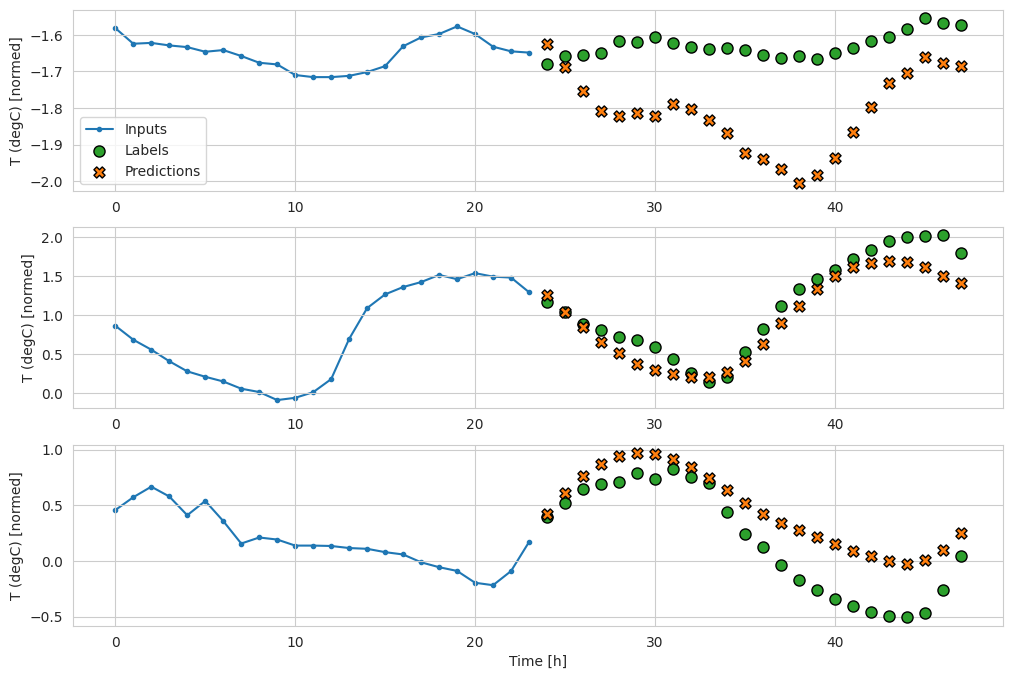

In [63]:

CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, kernel_size=CONV_WIDTH, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*train_df.shape[1], kernel_initializer=tf.zeros_initializer()),
    tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[1]])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

### 4) Multi-step LSTM (single-shot)

Um modelo recorrente pode aprender a usar um longo histórico de entradas, se for relevante para as previsões que o modelo está fazendo. Aqui, o modelo acumulará estado interno por 24 horas, antes de fazer uma única previsão para as próximas 24 horas.

Neste formato de single-shot, o LSTM só precisa produzir uma saída no último passo de tempo, então defina `return_sequences=False` em `tf.keras.layers.LSTM`.

![](images/multistep_lstm.png)

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.4019 - mae: 0.4449 - val_loss: 0.2289 - val_mae: 0.3051
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.2184 - mae: 0.2964 - val_loss: 0.2196 - val_mae: 0.2934
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.2090 - mae: 0.2855 - val_loss: 0.2162 - val_mae: 0.2881
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.2048 - mae: 0.2809 - val_loss: 0.2156 - val_mae: 0.2867
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.2018 - mae: 0.2779 - val_loss: 0.2148 - val_mae: 0.2862
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.1996 - mae: 0.2759 - val_loss: 0.2146 - val_mae: 0.2852
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.1978 - mae: 0.2743 - val_loss: 0.2143 - val_mae: 0.2845
Epoch 8/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.1962 - mae: 0.2730 - val_loss: 0.2139 - val_mae: 0.2841
Epoch 9/20
1532/1532 ━━━━━━━━━━━

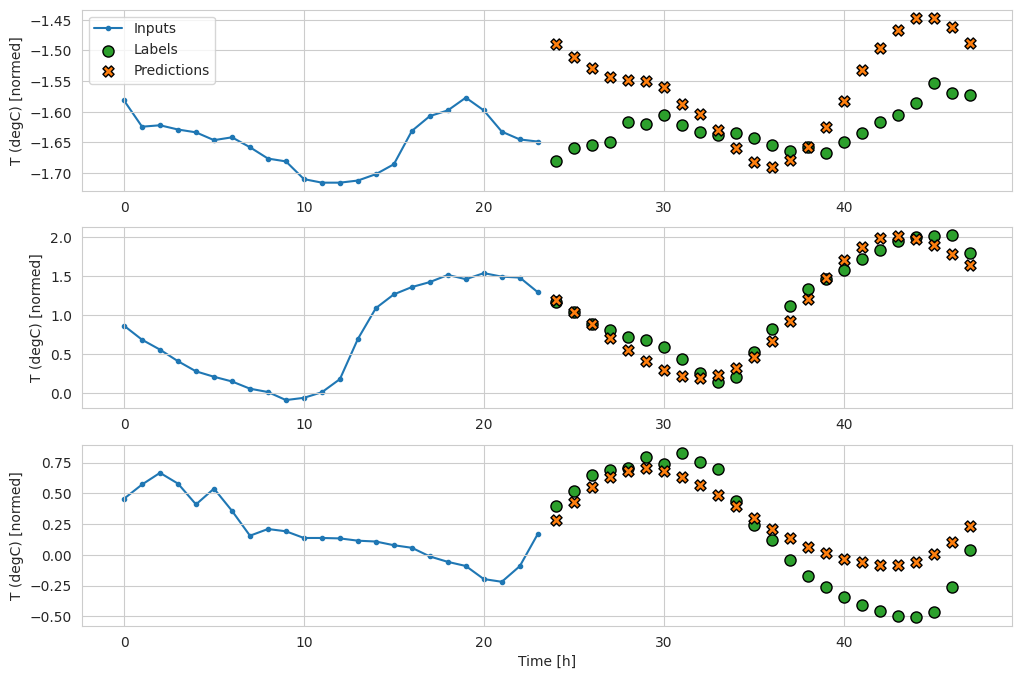

In [64]:

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS * train_df.shape[1], kernel_initializer=tf.zeros_initializer()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[1]])
])

history = compile_and_fit(multi_lstm_model, multi_window)
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

### 8.4 Modelo Autoregressivo
Os modelos acima preveem toda a sequência de saída em um único passo.

Em alguns casos, pode ser útil para o modelo decompor essa previsão em passos de tempo individuais. Então, a saída de cada modelo pode ser realimentada nele mesmo a cada passo e as previsões podem ser feitas condicionadas à anterior, como no clássico [Gerando Sequências com Redes Neurais Recorrentes](https://arxiv.org/abs/1308.0850).

Uma vantagem clara desse estilo de modelo é que ele pode ser configurado para produzir saídas com um comprimento variável.

Você poderia pegar qualquer um dos modelos de múltiplas saídas de um único passo treinados na primeira metade deste tutorial e executá-los em um loop de feedback autorregressivo, mas aqui você se concentrará em construir um modelo explicitamente treinado para fazer isso.
![](images/multistep_autoregressive.png)

#### RNN

Este tutorial constrói apenas um modelo RNN autorregressivo, mas esse padrão pode ser aplicado a qualquer modelo projetado para produzir um único passo temporal.

O modelo terá a mesma forma básica dos modelos LSTM de passo único anteriores: uma camada `tf.keras.layers.LSTM` seguida por uma camada `tf.keras.layers.Dense` que converte as saídas da camada LSTM em previsões do modelo.

Um `tf.keras.layers.LSTM` é um `tf.keras.layers.LSTMCell` envolto no nível superior `tf.keras.layers.RNN` que gerencia o estado e os resultados da sequência para você (Confira o guia Redes Neurais Recorrentes (RNN) com Keras para mais detalhes).

Neste caso, o modelo precisa gerenciar manualmente as entradas para cada passo, então ele usa `tf.keras.layers.LSTMCell` diretamente para a interface de passo temporal único.

Output shape (batch, time, features):  (32, 24, 19)
Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.4206 - mae: 0.4606 - val_loss: 0.2533 - val_mae: 0.3352
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2417 - mae: 0.3245 - val_loss: 0.2350 - val_mae: 0.3147
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2292 - mae: 0.3104 - val_loss: 0.2297 - val_mae: 0.3072
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2222 - mae: 0.3029 - val_loss: 0.2284 - val_mae: 0.3067
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2179 - mae: 0.2987 - val_loss: 0.2248 - val_mae: 0.3010
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2143 - mae: 0.2950 - val_loss: 0.2248 - val_mae: 0.3004
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2115 - mae: 0.2927 - val_loss: 0.2235 - val_mae: 0.2996
Epoch 8/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2094 - mae: 0.2907 - val_los

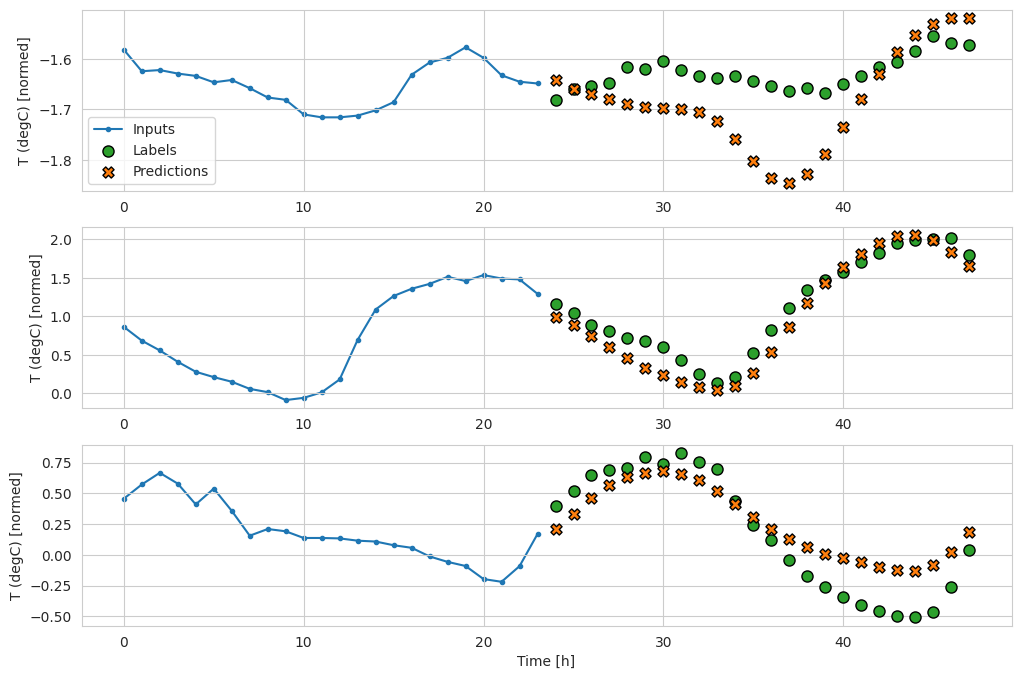

In [65]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.num_features = num_features
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)
        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)
        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state, training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

feedback_model = FeedBack(
    units=32,
    out_steps=OUT_STEPS,
    num_features=train_df.shape[1]
)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

history = compile_and_fit(feedback_model, multi_window)
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

## 9) Comparação de Resultados
Consolidamos as métricas em ambos os cenários (single-step e multi-step).

In [66]:
import numpy as np

print("\n=== Single-step Models ===")
for name, val in val_performance.items():
    print(name, "(Val):", val)
for name, testv in performance.items():
    print(name, "(Test):", testv)

print("\n=== Multi-step Models ===")
for name, valv in multi_val_performance.items():
    print(name, "(Val):", valv)
for name, testm in multi_performance.items():
    print(name, "(Test):", testm)



=== Single-step Models ===
Baseline (Val): {'loss': 0.08855374902486801, 'mae': 0.15893128514289856}
Dense (Val): {'loss': 0.06763086467981339, 'mae': 0.12742210924625397}
LSTM (Val): {'loss': 0.06139187514781952, 'mae': 0.12000222504138947}
Residual LSTM (Val): {'loss': 0.062111325562000275, 'mae': 0.1181444525718689}
Baseline (Test): {'loss': 0.09026193618774414, 'mae': 0.16375066339969635}
Dense (Test): {'loss': 0.06805222481489182, 'mae': 0.1290288269519806}
LSTM (Test): {'loss': 0.06204305216670036, 'mae': 0.12142325192689896}
Residual LSTM (Test): {'loss': 0.062456756830215454, 'mae': 0.11911103129386902}

=== Multi-step Models ===
Last (Val): {'loss': 0.6285412311553955, 'mae': 0.5007191300392151}
Repeat (Val): {'loss': 0.42702552676200867, 'mae': 0.39587467908859253}
Linear (Val): {'loss': 0.2560841739177704, 'mae': 0.30528783798217773}
Dense (Val): {'loss': 0.22192350029945374, 'mae': 0.2833831012248993}
Conv (Val): {'loss': 0.21699686348438263, 'mae': 0.2854865491390228}
LST

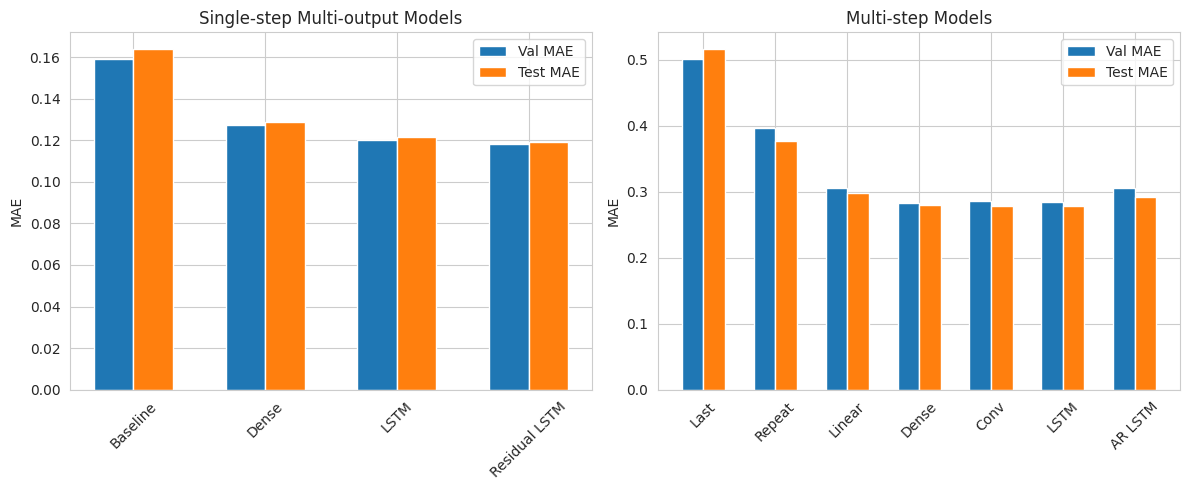

In [69]:
# Collect single-step metrics
model_names_single = list(performance.keys())
val_mae_single = [v['mae'] for v in val_performance.values()]
test_mae_single = [v['mae'] for v in performance.values()]

# Collect multi-step metrics
model_names_multi = list(multi_performance.keys())
val_mae_multi = [v['mae'] for v in multi_val_performance.values()]
test_mae_multi = [v['mae'] for v in multi_performance.values()]

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
width = 0.3

# Single-step bar chart (MAE multi-output)
x_s = np.arange(len(model_names_single))
axs[0].bar(x_s - width/2, val_mae_single, width, label='Val MAE')
axs[0].bar(x_s + width/2, test_mae_single, width, label='Test MAE')
axs[0].set_xticks(x_s)
axs[0].set_xticklabels(model_names_single, rotation=45)
axs[0].set_ylabel('MAE')
axs[0].set_title('Single-step Multi-output Models')
axs[0].legend()

# Multi-step bar chart
x_m = np.arange(len(model_names_multi))
axs[1].bar(x_m - width/2, val_mae_multi, width, label='Val MAE')
axs[1].bar(x_m + width/2, test_mae_multi, width, label='Test MAE')
axs[1].set_xticks(x_m)
axs[1].set_xticklabels(model_names_multi, rotation=45)
axs[1].set_ylabel('MAE')
axs[1].set_title('Multi-step Models')
axs[1].legend()

plt.tight_layout()
plt.show()

Os ganhos obtidos ao substituir um modelo denso por arquiteturas convolucionais e recorrentes foram limitados, representando apenas alguns pontos percentuais de melhoria, quando presentes. Além disso, o modelo autorregressivo apresentou um desempenho significativamente inferior. Assim, essas abordagens mais complexas podem não justificar o custo computacional e a implementação adicional neste caso específico. No entanto, sua experimentação foi essencial para descartar hipóteses e pode ser relevante para problemas específicos que se beneficiem de tais arquiteturas.

## 10) Conclusão
1. **Single-step** (prever apenas o próximo ponto (hora seguinte)):
   - Modelos como baseline, linear e denso podem ter desempenho razoável prevendo apenas 1 hora no futuro.

2. **Single-step Multi-output**: Prever o próximo ponto, mas várias variáveis ao mesmo tempo.

3. **Multi-step** (24h):
   - Precisamos de mais complexidade ou estratégias (ex.: single-shot ou autoregressivo) para lidar com a evolução de um dia inteiro.
   - Modelos mais complexos, como LSTM e Conv, têm um desempenho melhor, indicando que a capacidade de capturar dependências de longo prazo ou padrões locais é benéfica para previsões de múltiplos passos.

4. **Comparação** mostra que, em muitos casos, os modelos básicos (linear, denso) já atingem bons resultados, e CNN/LSTM podem trazer ganhos marginais dependendo da natureza dos dados.

### Possíveis Extensões
- Explorar **horizontes diferentes** (ex.: 48h, 72h).
- Incluir **MLflow** para rastrear experimentos.
- Servir o modelo com **FastAPI** e **Streamlit**.
- Ajustar hiperparâmetros.